# Artificial neural networks for QSAR
_by David Holmberg (August 2023)_
#### Dataset
For this exercise we will use the same dataset of aqueous solubility of 1142 diverse chemical compounds as you previously explored during the QSAR lab last week. However, here we will only use the PhysChem descriptors.

#### Modelling comparisons
1. Compare the results of linear regression to those of a simple neural network with no hidden layers and no non-linear activation functions
2. Compare the results of a a random forest regressor, a support vector regressor, and a neural network with two hidden layers (with non-linear activations) and dropout.

#### Aims
* to see the link between neural networks and linear regression
* to learn the basics of how to define, compile, fit and evaluate neural networks via TensorFlow.

#### Note
We will be using the open-source machine learning framework TensorFlow (https://www.tensorflow.org) and Keras (https://keras.io) for our neural networks. TensorFlow was developed by the Google Brain team and is today one of the most widely used machine learning frameworks in research and industry and Keras was/is the most popular higher-level API that runs atop TensorFlow. However, last year TensorFlow 2 was released. In TensorFow 2 (which we will use for all our neural network work) Keras is now fully integrated. This means that we get all the benefits of TensorFlow with a much easier (Keras-type) way to define and train models than was previously possible with TensorFlow 1.

## Load packages

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Pytorch and Pytorch Geometric
import torch as tch
import torch.nn as nn
import torch.optim as optim

from torch_geometric.nn import GCNConv, summary as gsummary
from torch_geometric.data import Data, DataLoader

from rdkit import Chem
from rdkit.Chem import AllChem

# Helper libraries
from torchsummary import summary as asummary
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = ""
# device = tch.device("cuda" if tch.cuda.is_available() else "cpu")
tch.backends.cudnn.enabled = False
tch.cuda.is_available = lambda : False
device = tch.device('cpu')

RDKit WARNING: [11:26:00] Enabling RDKit 2019.09.1 jupyter extensions
[11:26:00] Enabling RDKit 2019.09.1 jupyter extensions


## functions
Run these cells to have access to the necessary functions for the lab.

In [2]:

def plot_history(train_losses, val_losses, model_name):
    fig = plt.figure(figsize=(15, 5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(train_losses)
    ax.plot(val_losses)
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Test'], loc='upper right')
    ax = fig.add_subplot(122)
    ax.plot(np.log(train_losses))
    ax.plot(np.log(val_losses))
    ax.set(title=model_name + ': Log model loss', ylabel='Log loss', xlabel='Epoch')
    ax.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    plt.close()

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=128)
    return list(fp.ToBitString())

def smiles_to_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol

def read_smiles_data(path_data):
    df = pd.read_csv(path_data, sep=',')
    df['fingerprint'] = df['SMILES'].apply(smiles_to_fingerprint)
    df['fingerprint'] = df['fingerprint'].apply(lambda x: [int(bit) for bit in x])
    df['mol'] = df['SMILES'].apply(smiles_to_mol)
    return df

def make_pyg(row):
    # Create node features
    mol = row['mol']
    atom_features = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    x1 = tch.tensor(atom_features, dtype=tch.float).view(-1, 1)
    x2 = tch.tensor(row['fingerprint'], dtype=tch.float)
    y = tch.tensor(row['measured.log.solubility.mol.L.'], dtype=tch.float).view(-1, 1)
    # y = tch.tensor(df['measured.log.solubility.mol.L.'].values, dtype=tch.float).view(-1, 1)
    # Assuming fingerprint is a 1D tensor
    # fingerprint = tch.tensor(fingerprint, dtype=tch.float).view(1, -1)

    # Duplicate fingerprint for each atom and concatenate
    x2_repeated = x2.repeat(x1.shape[0], 1)
    x = tch.cat([x1, x2_repeated], dim=1)
    
    # Create edge features (connectivity)
    edge_indices = []
    edge_features = []
    
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_indices.append((i, j))
        edge_features.append([bond.GetBondTypeAsDouble()])  # Bond type (as double)
    
    edge_index = tch.tensor(edge_indices, dtype=tch.long).t().contiguous()
    edge_attr = tch.tensor(edge_features, dtype=tch.float).view(-1, 1)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)


## Load and preprocess data

#### Load and check shape of X and y

In [3]:
df = read_smiles_data('data/solubility.csv')
df.head()

,Compound.ID,measured.log.solubility.mol.L.,ESOL.predicted.log.solubility.mol.L.,SMILES,fingerprint,mol
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f73bdb2a5e0>
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f73bdb2a2e0>
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f73bdb2a700>
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f73bdb2a400>
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f73bdb2a040>


In [4]:
X = np.load('data/X_qsar.npy')
y = np.load('data/y_qsar.npy')


data_pyg = df.apply(make_pyg, axis=1)
data_pyg = data_pyg[data_pyg.apply(lambda x: len(x.edge_index.shape) != 1)]
data_pyg.reset_index(drop=True, inplace=True)
#DEBUGG
dbl = int(len(data_pyg) * 0.3)
dbi = np.arange(dbl)
data_pyg= data_pyg[dbi[:dbl]]
data_pyg.reset_index(drop=True, inplace=True)

print(X.shape)
# print(Xold.shape)
print(y.shape)

(1126, 8)
(1126,)


#### Split into training and test sets and standardize the data
Here we will just have a training and test set, so our results will not be quite as rigerous as those you got with cross-validation in the supervised machine learning lab.

In [5]:
n_train = int(len(y) * 0.7) # 70% of data for training and 30% for testing

random.seed(1234)
indices = np.arange(len(y))
random.shuffle(indices)

# X_train0 is our training data prior to standardization
X_train0, X_test0 = X[indices[:n_train]], X[indices[n_train:]]
y_train, y_test = y[indices[:n_train]], y[indices[n_train:]]

# standardize X_train0 and X_test0 to give X_train and X_test
scaler = StandardScaler().fit(X_train0)
X_train = scaler.transform(X_train0)
X_test = scaler.transform(X_test0)


# Here we split the molecular data into a train and a test set
n_train = int(len(data_pyg) * 0.7) # 70% of data for training and 30% for testing
# random.seed(1234)
indices = np.arange(n_train)
# print(indices[-1])
data_train = data_pyg[indices[:n_train]]
data_train.reset_index(drop=True, inplace=True)
data_test = data_pyg[~data_pyg.isin(data_train)]
data_test.reset_index(drop=True, inplace=True)


## Linear Regression
## Random Forest Regressor & Support Vector Regressor
For comparative purposes, with the results we will explore later with a more involved neural network architectures than the one above, we will build a Linear Regression, Random Forest and Support Vector model. For these three machine learning algorithms we will just use the default hyper parameter settings, which are often a good place to start. This means that you will just have () after the model definition, as you did for the linear regression with LinearRegression(). To change the hyper parameters from the defaults one needs to specify them within the braces.

The code cells for the random forest and support vector regressors have been left blank below. You should fill in these cells. You should define the models, fit them, make predictions from them, compute their MSEs and print out the results.

* hint 1: look to the cell where we 'Load packages' to get the right model definition for the two machine learning methods
* hint 2: look at the cell with Linear Regression. It should be similar.

In [6]:
#Linear Regression
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)
LR_pred = LR_model.predict(X_test)
LR_mse = mean_squared_error(y_test, LR_pred)
print('Linear Regression: MSE = ' + str(np.round(LR_mse, 3)))

Linear Regression: MSE = 0.938


#### Random Forest Regressor

In [7]:
RF_model = RandomForestRegressor()
RF_model.fit(X_train, y_train)
RF_pred = RF_model.predict(X_test)
RF_mse = mean_squared_error(y_test, RF_pred)
print('Random Forest Regressor: MSE = ' + str(np.round(RF_mse, 3)))

Random Forest Regressor: MSE = 0.451


#### Support Vector Regressor

In [8]:
SV_model = SVR()
SV_model.fit(X_train, y_train)
SV_pred = SV_model.predict(X_test)
SV_mse = mean_squared_error(y_test, SV_pred)
print('Support Vector Regressor: MSE = ' + str(np.round(SV_mse, 3)))

Support Vector Regressor: MSE = 0.488


## Artifical neural network as a linear regression
If we define a neural network with no hidden layers and no non-linear activations we essentailly get the same results as we do with basic linear regression. The results below should help clarify that to you (there are some minor differences hovever, hence the MSE for the neural network will not be _exactly_ the same as the results above for linear regression, but they are neverthelss very close).

<p>
    <img src="figs/lin-reg.png" alt="drawing" style="width:1200px;"/>
    <center>Figure 1. Our neural network version of linear regression.</center>
</p>

#### Define model
You will need to convert the data into tensors and define the model to use Neural Networks. IN this particular case, you'll get some help - but keep note of how it's done, you *will* have to do it yourselves in the rest of the assignment.

In [9]:
X_train_tensor = tch.tensor(X_train, dtype=tch.float32).to(device)
y_train_tensor = tch.tensor(y_train, dtype=tch.float32).to(device).unsqueeze(1)  # Add dimension for regression
X_test_tensor = tch.tensor(X_test, dtype=tch.float32).to(device)
y_test_tensor = tch.tensor(y_test, dtype=tch.float32).to(device).unsqueeze(1)
# print(y_test_tensor)
# print(y_train_tensor)

In [10]:

class ANN1(nn.Module):
    def __init__(self, input_dim):
        super(ANN1, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 1)  # Output layer with 1 nodes
        self.relu = nn.ReLU()

    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### Innitialize the model and set optimizer and learning rate hyperparameters
The learning rate and optimizer chosen below are both things that can be changed when one explores hyper parameter options, different architectures and what not. Below we use a learning rate (lr) of 0.001 (a common default learning rate) and the 'Adam' optimizer.

In [11]:
# tch.device('cpu')
input_dim = X_train.shape[1]
ann1_model = ANN1(input_dim).to(device).float()
asummary(ann1_model.to(device), input_size=(input_dim,))
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(ann1_model.parameters(), lr=0.001)  # Adjust learning rate as needed


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]             144
              ReLU-2                   [-1, 16]               0
            Linear-3                    [-1, 1]              17
Total params: 161
Trainable params: 161
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Train the model
Here you will train the model

In [12]:
num_epochs = 15  # Adjust as needed
train_losses = []
val_losses = []
ann1_model.to(device)
for epoch in range(num_epochs):
    ann1_model.train()
    optimizer.zero_grad()
    outputs = ann1_model(X_train_tensor.to(device))
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    ann1_model.eval()
    with tch.no_grad():
        val_outputs = ann1_model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
    # if (epoch + 1) % 100 == 0:
    #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')


Epoch [1/15], Loss: 12.3269, Val Loss: 11.1009
Epoch [2/15], Loss: 12.2676, Val Loss: 11.0443
Epoch [3/15], Loss: 12.2084, Val Loss: 10.9877
Epoch [4/15], Loss: 12.1493, Val Loss: 10.9313
Epoch [5/15], Loss: 12.0904, Val Loss: 10.8750
Epoch [6/15], Loss: 12.0315, Val Loss: 10.8188
Epoch [7/15], Loss: 11.9728, Val Loss: 10.7626
Epoch [8/15], Loss: 11.9141, Val Loss: 10.7066
Epoch [9/15], Loss: 11.8556, Val Loss: 10.6508
Epoch [10/15], Loss: 11.7973, Val Loss: 10.5951
Epoch [11/15], Loss: 11.7391, Val Loss: 10.5395
Epoch [12/15], Loss: 11.6810, Val Loss: 10.4841
Epoch [13/15], Loss: 11.6232, Val Loss: 10.4287
Epoch [14/15], Loss: 11.5654, Val Loss: 10.3734
Epoch [15/15], Loss: 11.5076, Val Loss: 10.3182


#### Evaluate the model

ANN Regression: MSE = 10.318


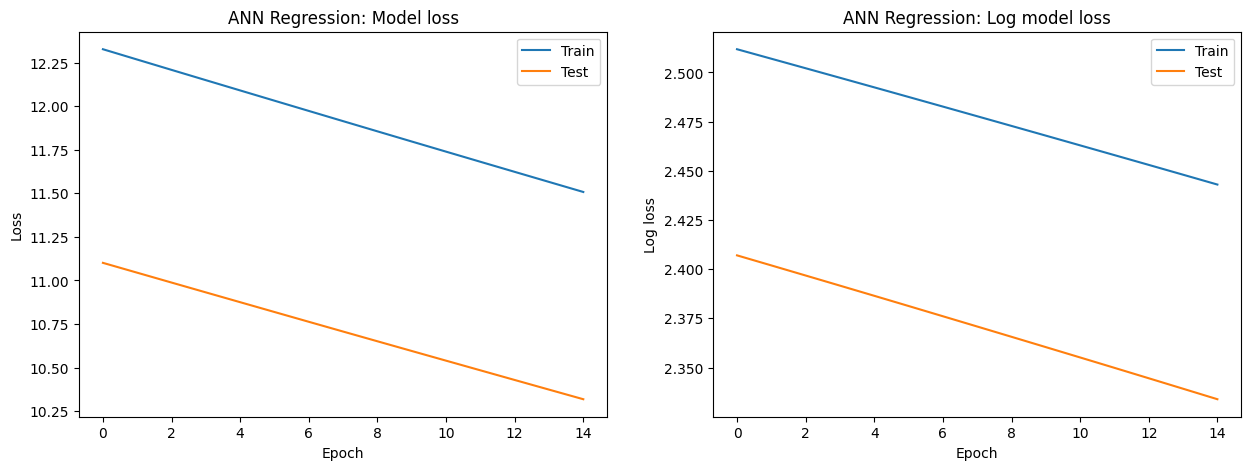

In [13]:
# Evaluate the model
ann1_model.eval()
with tch.no_grad():
    y_pred = ann1_model(X_test_tensor)
    ann_mse = mean_squared_error(y_test_tensor, y_pred)
    print('ANN Regression: MSE = {:.3f}'.format(ann_mse))

# Plot training history
plot_history(train_losses, val_losses, 'ANN Regression')

## Going deeper with ANNs 
In the cells below we define, compile, fit and evaluate a neural network model with:
* two hiiden layers, each with 32 neurons and non-linear activations (relu)
* a dropout layer at the end with a dropout rate of 0.2

<p>
    <img src="figs/relu-activation.png" alt="drawing" style="width:500px;"/>
    <center>Figure 2. relu activation.</center>
</p>

Dropout can help to avoid overfitting, much as L1 and L2 regularizations do (as you explored in the supervise machine learning lab). In the model loss plots (below) this stops the test loss from increasing as you train for more epochs.

Some quotes from a paper co-authored by members of our group called "Deep Learning in Image Cytometry: A Review" (https://onlinelibrary.wiley.com/doi/full/10.1002/cyto.a.23701):

"_Overfitting occurs when the parameters of a model fit too closely to the input training data, without capturing the underlying distribution, and thus reducing the model’s ability to generalize to other datasets_".

DROPOUT: "_A regularization technique that reduces the interdependent learning among the neurons to prevent overfitting. Some neurons are randomly “dropped,” or disconnected from other neurons, at every training iteration, removing their influence on the optimization of the other neurons. Dropout creates a sparse network composed of several networks—each trained with a subset of the neurons. This transformation into an ensemble of networks hugely decreases the possibility of overfitting, and can lead to better generalization and increased accuracy_".

<p>
    <img src="figs/dropout.png" alt="drawing" style="width:1200px;"/>
    <center>Figure 3. Dropout.</center>
</p>



In [14]:
class ANN2(nn.Module):
    def __init__(self, input_dim):
        super(ANN2, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)  # Output layer with 1 node
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [15]:
# Initialize the ANN2 model
input_dim = X_train.shape[1]
ann2_model = ANN2(input_dim)
asummary(ann2_model, input_size=(input_dim,))
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(ann2_model.parameters(), lr=0.001)  # Adjust learning rate as needed


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             288
              ReLU-2                   [-1, 32]               0
           Dropout-3                   [-1, 32]               0
            Linear-4                   [-1, 32]           1,056
              ReLU-5                   [-1, 32]               0
           Dropout-6                   [-1, 32]               0
            Linear-7                    [-1, 1]              33
Total params: 1,377
Trainable params: 1,377
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [16]:
num_epochs = 15  # Adjust as needed
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    ann2_model.train()
    optimizer.zero_grad()
    outputs = ann2_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    ann2_model.eval()
    with tch.no_grad():
        val_outputs = ann2_model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
    # if (epoch + 1) % 100 == 0:
    #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')


Epoch [1/15], Loss: 13.9037, Val Loss: 12.8507
Epoch [2/15], Loss: 13.7812, Val Loss: 12.7417
Epoch [3/15], Loss: 13.7270, Val Loss: 12.6331
Epoch [4/15], Loss: 13.6147, Val Loss: 12.5246
Epoch [5/15], Loss: 13.4046, Val Loss: 12.4163
Epoch [6/15], Loss: 13.3236, Val Loss: 12.3078
Epoch [7/15], Loss: 13.1479, Val Loss: 12.1990
Epoch [8/15], Loss: 13.0779, Val Loss: 12.0903
Epoch [9/15], Loss: 13.0510, Val Loss: 11.9812
Epoch [10/15], Loss: 12.8110, Val Loss: 11.8713
Epoch [11/15], Loss: 12.7195, Val Loss: 11.7607
Epoch [12/15], Loss: 12.6128, Val Loss: 11.6488
Epoch [13/15], Loss: 12.4808, Val Loss: 11.5358
Epoch [14/15], Loss: 12.3225, Val Loss: 11.4217
Epoch [15/15], Loss: 12.2040, Val Loss: 11.3064


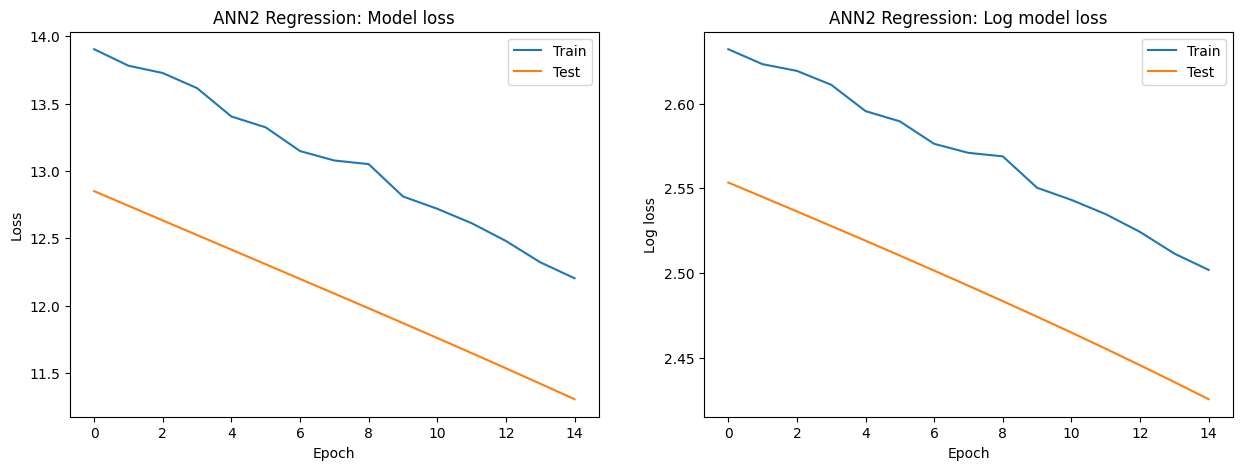

In [17]:
plot_history(train_losses, val_losses, 'ANN2 Regression')

### Testing GNNs
So, now you've tested regression on molecular descriptors with ANNs. ANother option that is gaining traction in the research world is using Graph Neural Networks or, as they can also be called, Graph Convolutional Networks. You will be using an extension library called Pytorch.Geometric for this. Training and Evaluation looks the same.

In [18]:
# # Assuming fingerprints and solubilities are your node features
# fingerprints = tch.tensor(df['fingerprint'].to_list(), dtype=tch.float)
# solubilities = tch.tensor(df['measured.log.solubility.mol.L.'].values, dtype=tch.float).view(-1, 1)
# Xg = tch.cat([fingerprints, solubilities], dim=1)  # Concatenating to create node feature matrix

# # For edges, since it's not provided let's assume a fully connected graph
# num_nodes = len(df)
# edge_index = tch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=tch.long).t().contiguous()

# # data = Data(x=Xg, edge_index=edge_index)
# # print(Xg.size(1))

# print(data_train.iloc[5].x.size(1))

In [19]:
class GNN1(nn.Module):
    def __init__(self, input_dim):
        super(GNN1, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.conv2 = GCNConv(32, 16)
        self.fc3 = nn.Linear(16, 1)  # Output layer with 1 node
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        # x, edge_index = data.x, data.edge_index
        x = self.relu(self.conv1(x, edge_index))
        x = self.relu(self.conv2(x, edge_index))
        x = self.fc3(x)
        x = tch.mean(x, dim=0, keepdim=True)
        return x
    

In [20]:
# Initialize the GNN1 model
input_dim = data_train.iloc[5].x.size(1)
gnn1_model = GNN1(input_dim)
#Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(gnn1_model.parameters(), lr=0.001)  # Adjust learning rate as needed

In [21]:
# data_pyg = df.apply(make_pyg, axis=1)
# data_pyg = data_pyg[data_pyg.apply(lambda x: len(x.edge_index.shape) != 1)]
# data_pyg.reset_index(drop=True, inplace=True)

# dbl = int(len(data_pyg) * 0.3)
# dbi = np.arange(dbl)
# data_pyg= data_pyg[dbi[:dbl]]
# data_pyg.reset_index(drop=True, inplace=True)


# n_train = int(len(data_pyg) * 0.7) # 70% of data for training and 30% for testing
# # random.seed(1234)
# indices = np.arange(n_train)
# # print(indices[-1])
# data_train = data_pyg[indices[:n_train]]
# data_train.reset_index(drop=True, inplace=True)
# data_test = data_pyg[~data_pyg.isin(data_train)]
# data_test.reset_index(drop=True, inplace=True)



In [22]:
num_epochs = 2
train_losses = []
val_losses = []

# Create DataLoader with batch size of 1
t_loader = DataLoader(data_train, batch_size=1, shuffle=True)
v_loader = DataLoader(data_test, batch_size=1, shuffle=True)
for epoch in range(num_epochs):
    # Training Phase
    gnn1_model.train()
    train_loss_items = []
    for batch in t_loader:
        optimizer.zero_grad()
        # Use Batch Data object in forward pass
        outputs = gnn1_model(batch.x, batch.edge_index)
        loss = criterion(outputs, batch.y)
        loss.backward()
        optimizer.step()
        train_loss_items.append(loss.item())
    avg_train_loss = sum(train_loss_items) / len(train_loss_items)
    train_losses.append(avg_train_loss)
    # Validation Phase (assuming you have a separate validation loader)
    gnn1_model.eval()
    
    val_loss_items = []
    with tch.no_grad():
        for val_batch in v_loader:
            val_outputs = gnn1_model(val_batch.x, val_batch.edge_index)
            val_loss = criterion(val_outputs, val_batch.y)
            val_loss_items.append(val_loss.item())
    
    avg_val_loss = sum(val_loss_items) / len(val_loss_items)
    val_losses.append(avg_val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Val Loss: {avg_val_loss:.4f}')

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [1/2], Loss: 5.1490, Val Loss: 2.9859
Epoch [2/2], Loss: 3.0017, Val Loss: 2.1919


In [23]:
gnn1_model.eval()
with tch.no_grad():
    y_pred = ann2_model(X_test_tensor)
    ann2_mse = mean_squared_error(y_test_tensor, y_pred)
    print('GNN1 Regression: MSE = {:.3f}'.format(ann2_mse))

GNN1 Regression: MSE = 11.306


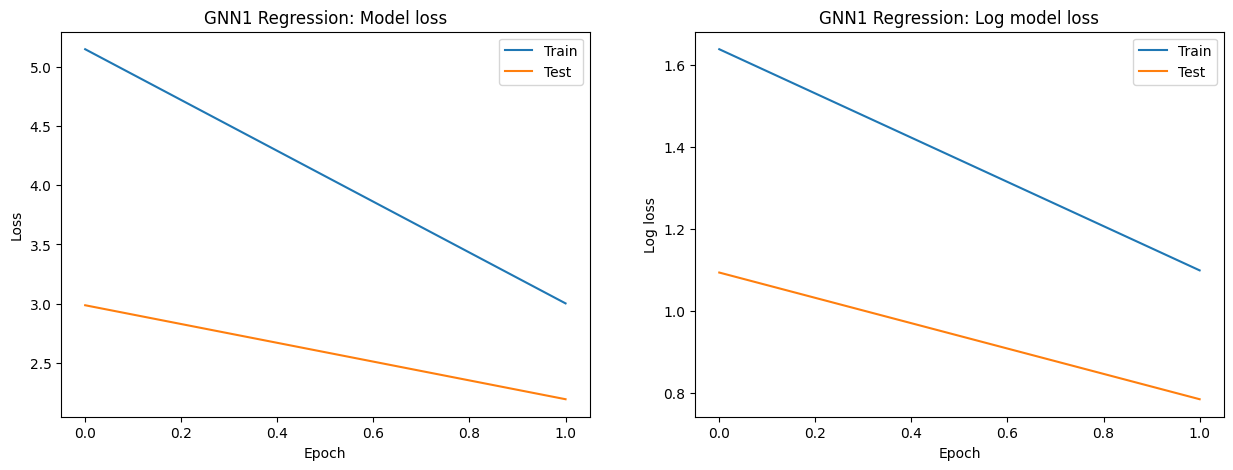

In [24]:
plot_history(train_losses, val_losses, 'GNN1 Regression')